# MNIST digit classification

For detailed explanations, refer to:
* this [link](https://victorzhou.com/blog/keras-neural-network-tutorial/) for the FFNN

In [13]:
# import
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dropout

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style('white')

from random import randrange

In [2]:
# load data
data_set = pd.read_csv('./input/train.csv')
print(data_set.shape)

(42000, 785)


In [3]:
data_set.sample(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
12455,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18930,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16704,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


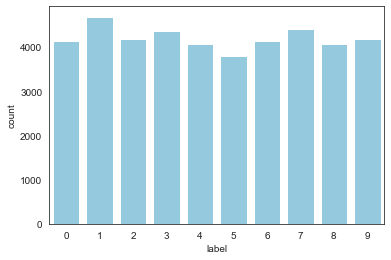

In [4]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

# check distribution of the handwritten digits
sns.countplot(y, color='skyblue');

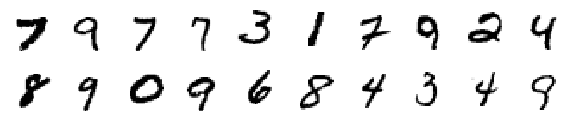

In [5]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(2, 10, figsize=(10, 2)) # 2 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [6]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [14]:
# define model
model = Sequential([
  Dense(128, activation='relu', input_shape=(784,)),  # change layer size from 64 to 128
  Dropout(0.25),
  Dense(64, activation='sigmoid'), # change activation function from relu to sigmoid
  Dropout(0.25),    
  Dense(10, activation='softmax'),
])

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
# Train the model
n_epochs = 10 # increase nbr of epochs from 5 to 10

history = model.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_test, to_categorical(y_test)), 
    batch_size=32,
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37800/37800 [==============================] - 24s 636us/step - loss: 0.5355 - acc: 0.8479 - val_loss: 0.2163 - val_acc: 0.9352
Epoch 2/10
37800/37800 [==============================] - 23s 598us/step - loss: 0.2310 - acc: 0.9329 - val_loss: 0.1583 - val_acc: 0.9495
Epoch 3/10
37800/37800 [==============================] - 22s 583us/step - loss: 0.1773 - acc: 0.9475 - val_loss: 0.1352 - val_acc: 0.9595
Epoch 4/10
37800/37800 [==============================] - 22s 581us/step - loss: 0.1451 - acc: 0.9578 - val_loss: 0.1099 - val_acc: 0.9636
Epoch 5/10
37800/37800 [==============================] - 24s 633us/step - loss: 0.1232 - acc: 0.9642 - val_loss: 0.1125 - val_acc: 0.9650
Epoch 6/10
37800/37800 [==============================] - 22s 594us/step - loss: 0.1074 - acc: 0.9678 - val_loss: 0.1066 - val_acc: 0.9667
Epoch 7/10
37800/37800 [==============================] - 24s 643us/step - loss: 0.1005 - acc: 0.9688 - val_loss: 0.1

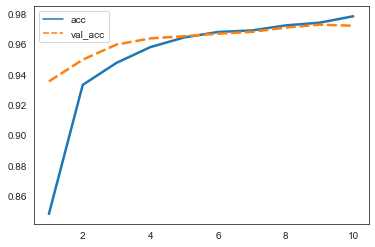

In [16]:
# load history in dataframe and plot accuracy for training and test data
df_history = pd.DataFrame(history.history, index=[i+1 for i in range(n_epochs)])  
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);

In [17]:
# save weights
model.save_weights('./output/mnist_mlp_dropout.h5')

# load test data
test = pd.read_csv('./input/test.csv')

# prediction
y_test = model.predict(test)

In [18]:
# convert to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)

submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('./output/submission-mlp_dropout.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)